# Brand Sentiment Analysis of Twitter Posts

## Setup

In [193]:
import datetime
import itertools
import json
import os
import pickle
import re
import string
import time
from pprint import pprint
from typing import Any, Callable, Dict, List, Optional, Tuple, Union

In [194]:
# PULL FROM GIT LARGE FILE STORAGE (LFS)
!git lfs pull --include="datasets/*"
!git lfs pull --include="cache/*"
!git lfs pull --include="*.mp4"
!git lfs pull --include="Final-Project-Team-2.mp4"

In [195]:
# SAVE PROJECT VISUALIZATIONS/ARTIFACTS IN THE REPORT DIRECTORY
os.makedirs("report", exist_ok=True)

In [196]:
from functools import wraps


class Metrics:
    """
    A class to hold metrics for monitoring performance.

    This class is a singleton, meaning that there is only one instance of the class throughout the entire program.
    All functions decorated with @measure_time share the same Metrics object.

    Attributes:
        metrics (dict): A dictionary to store the metrics.
    """

    _instance = None

    def __new__(cls):
        """
        Overrides the default object creation method to implement the singleton pattern.

        Returns:
            Metrics: The singleton instance of the Metrics class.
        """
        if cls._instance is None:
            cls._instance = super(Metrics, cls).__new__(cls)
            cls._instance.metrics = {}
        return cls._instance

    def __init__(self):
        """Initializes the Metrics class with an empty dictionary."""
        self.metrics: dict[str, float] = {}

    def add_metric(self, key: str, value: float) -> None:
        """
        Adds a new metric to the dictionary or appends to an existing one.

        Args:
            key (str): The name of the metric.
            value (float): The value of the metric.
        """
        if key in self.metrics:
            self.metrics[key] += value
        else:
            self.metrics[key] = value

    def get_metrics(self) -> dict[str, float]:
        """
        Returns the dictionary of metrics.

        Returns:
            dict: The dictionary of metrics.
        """
        return self.metrics

    def __str__(self) -> str:
        """Returns a string representation of the metrics."""
        return "\n".join(f"{k}: {v}" for k, v in self.metrics.items())

    def __getitem__(self, key: str) -> float:
        """
        Returns the value of the metric with the given key.

        Args:
            key (str): The key of the metric.

        Returns:
            float: The value of the metric.
        """
        return self.metrics.get(key)

    def __setitem__(self, key: str, value: float) -> None:
        """
        Sets the value of the metric with the given key.

        Args:
            key (str): The key of the metric.
            value (float): The value of the metric.
        """
        self.metrics[key] = value

    def __len__(self) -> int:
        """
        Returns the number of metrics.

        Returns:
            int: The number of metrics.
        """
        return len(self.metrics)

    def __contains__(self, key: str) -> bool:
        """
        Checks if the metric with the given key exists.

        Args:
            key (str): The key of the metric.

        Returns:
            bool: True if the metric exists, False otherwise.
        """
        return key in self.metrics

    def clear_metrics(self) -> None:
        """Clears all the metrics."""
        self.metrics.clear()

    def remove_metric(self, key: str) -> None:
        """
        Removes the metric with the given key.

        Args:
            key (str): The key of the metric.
        """
        if key in self.metrics:
            del self.metrics[key]

    def update_metric(self, key: str, value: float) -> None:
        """
        Updates the value of the metric with the given key.

        Args:
            key (str): The key of the metric.
            value (float): The new value of the metric.
        """
        if key in self.metrics:
            self.metrics[key] = value

    def print_metrics(self) -> None:
        """Prints all the metrics in a nice format."""
        print("Metrics:")
        sorted_metrics = sorted(
            self.metrics.items(), key=lambda item: item[1], reverse=True
        )
        for key, value in sorted_metrics:
            print(f"  {key}: {value:.2f} seconds")
        print(f"Total time: {sum(self.metrics.values()):.2f} seconds")


def measure_time(run_name: str):
    """
    A decorator factory that measures the time taken by a function and logs it to the Metrics singleton.

    Args:
        run_name (str): The name of the run. This is used to differentiate metrics among different runs.

    Returns:
        Callable: The decorator that wraps the function with timing and logging.
    """

    def decorator(func: Callable[..., Any]) -> Callable[..., Any]:
        """
        The actual decorator that wraps the function with timing and logging.

        Args:
            func (Callable): The function to be timed and logged.

        Returns:
            Callable: The wrapped function.
        """

        def wrapper(*args, **kwargs):
            """
            The wrapper function that adds timing and logging to the original function.

            Args:
                *args: The positional arguments for the original function.
                **kwargs: The keyword arguments for the original function.

            Returns:
                The result of the original function.
            """
            # START TIMER
            start_time = time.time()
            # CALL FUNCTION
            result = func(*args, **kwargs)
            # CALCULATE ELAPSED TIME
            total_time = time.time() - start_time
            # LOG RESULT
            metrics.add_metric(f"{run_name}", total_time)
            print(f"{run_name}...{total_time:.2f} seconds")
            return result

        return wrapper

    return decorator


metrics = Metrics()

### Package Management

We define a list of required packages and a function for installing them. This function, `handle_packages`, checks for each package in the system. If a package is not found, it is installed quietly using the pip package manager. 

By invoking `handle_packages` with the list of required packages, we make sure all project dependencies are satisfied, setting up a reliable and reproducible environment for our project.

In [197]:
# INSTALL REQUIRED PACKAGES FOR PROJECT
PACKAGES = [
    "matplotlib",
    "numpy",
    "openai",
    "pandas",
    "python-dotenv",
    "seaborn",
    "tweet-preprocessor",
    "wandb",
]


@measure_time("installing required packages")
def handle_packages(packages: list) -> None:
    """Quietly installs a package if it is not already installed.

    Args:
        packages (list): The list of packages to install.

    Raises:
        ImportError: If the package is not installed, install it.
    """
    for package in packages:
        try:
            __import__(package)
        except ImportError:
            os.system(f"pip install -q {package}")


handle_packages(PACKAGES)

installing required packages...3.56 seconds


### Setting Up Data Analysis and Visualization Tools

We import data handling and visualization libraries and configure them for ideal display. These steps prepare our environment for efficient data analysis and visualization tasks.

In [198]:
# STANDARD DATA MANIPULATION/VISUALIZATION LIBRARIES
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# CONFIGURE
pd.set_option("display.max_colwidth", 80)

# SET MATPLOTLIB STYLE TO 'fivethirtyeight'
plt.style.use("fivethirtyeight")

### Loading Environment Variables

We load environment variables from a `.env` file using the `dotenv` package. This file has key-value pairs of environment variables, which are then added to the system's environment variables. This approach lets us manage sensitive information securely and consistently across different project stages.

In [199]:
# LOAD ENVIRONMENT VARIABLES
import dotenv

ENVIRONMENT = dotenv.dotenv_values()
for key in ENVIRONMENT:
    os.environ[key] = ENVIRONMENT[key]

## Exploratory Data Analysis (EDA)

### Retrieving and Preparing the Sentiment140 Dataset

The Sentiment140 dataset, available at <http://help.sentiment140.com/for-students>, is a collection of 1.6 million tweets with sentiment labels. 

It is used for discovering the sentiment of a brand, product, or topic on Twitter.

The dataset, provided as a CSV file with emoticons removed, includes tweet content and sentiment labels. We extract these parts and remap the sentiment labels for easier interpretation in future analyses.

The dataset has 6 fields:
1. `target` — the polarity of the tweet (0 = negative, 2 = neutral, 4 = positive)
1. `id` — the id of the tweet (2087)
1. `date` — the date of the tweet (Sat May 16 23:58:44 UTC 2009)
1. `flag` — the query (lyx). If there is no query, then this value is NO_QUERY.
1. `user` — the user that tweeted (robotickilldozr)
1. `text` — the text of the tweet (Lyx is cool)

In [200]:
df_train = pd.read_csv(
    "datasets/training.1600000.processed.noemoticon.csv",
    encoding="ISO-8859-1",
    names=["target", "ids", "date", "flag", "user", "text"],
    header=None,
)

# GET TWEETS AND SENTIMENT LABELS
df_train = df_train[["text", "target"]]

# REMAP SENTIMENT LABELS TO 0 = negative, 1 = positive (instead of 0 = negative, 4 = positive)
df_train["target"] = df_train["target"].replace(4, 1)

### Class Balance

We ensure class balance in our dataset by counting the number of positive and negative tweets. Class balance is important because the model is trained on an equal number of instances from each class, preventing bias towards a particular sentiment. 

We generate a bar plot showing the distribution of sentiments in the training dataset, which indicates whether models will be trained on a balanced set of samples.

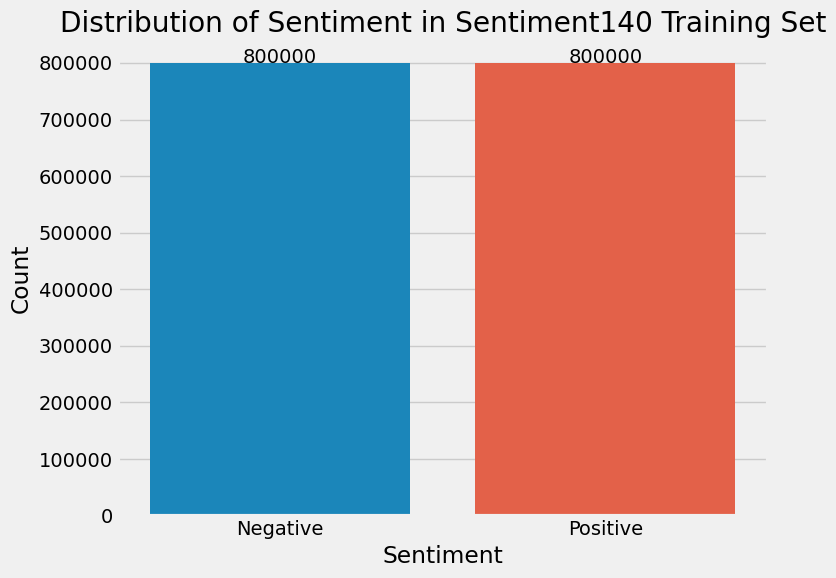

In [201]:
# SHOW SENTIMENT DISTRIBUTION IN TRAINING SET
distribution = df_train["target"].value_counts()
plt.figure(figsize=(8, 6))
sns.barplot(x=distribution.index, y=distribution.values)
plt.title("Distribution of Sentiment in Sentiment140 Training Set")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.xticks([0, 1], ["Negative", "Positive"])

for i, v in enumerate(distribution.values):
    # ADD COUNTS ABOVE BARS
    plt.text(i, v, str(v), ha="center")

# SAVE VISUALIZATION
plt.tight_layout()
plt.savefig("report/sentiment_distribution.png", dpi=300)

plt.show()

### Word Cloud

A word cloud is a visual representation where the most often occurring words are displayed larger than less common words. This visualization gives a quick understanding of the key themes or topics in the text data.

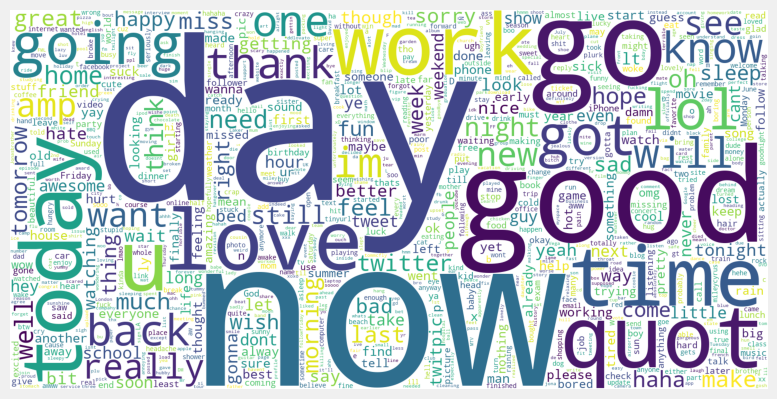

generating word cloud from training data...17.50 seconds


In [202]:
from wordcloud import WordCloud


@measure_time("generating word cloud from training data")
def generate_wordcloud(df_train):
    """
    Generate a wordcloud from a dataframe.

    Args:
        df_train (DataFrame): The dataframe containing the text data.

    Returns:
        None
    """
    wordcloud = WordCloud(
        width=1600,
        height=800,
        background_color="white",
        min_font_size=10,
        max_words=1000,
        collocations=False,
    )

    wordcloud.generate(" ".join(df_train["text"].tolist()))

    plt.figure(figsize=(8, 8))
    plt.imshow(wordcloud)
    plt.axis("off")

    # SAVE VISUALIZATION
    plt.tight_layout()
    plt.savefig("report/wordcloud.png", dpi=300)

    plt.show()


generate_wordcloud(df_train)

## Preprocessing

Preprocessing is a key step in Natural Language Processing (NLP) to improve the performance and accuracy of the models. The aim is to get the text data ready for machine learning algorithms. 

In its raw form, text data can be messy and unstructured, making it hard for a machine-learning model to understand and learn from. Preprocessing cleans up the data by removing unnecessary information like punctuation and common words that add little meaning or converting all text to lowercase so the model does not get confused by the same word in different cases. Transforming text into a clean and standardized form makes it easier for machine learning models to analyze the data and perform tasks like classification, prediction, or translation.

In [203]:
# SELECT BRANDS FROM CATEGORIES

technology = [
    "oracle",
    "ibm",
    "lenovo",
    "sony",
    "adobe",
    "apple",
    "facebook",
    "dell",
    "microsoft",
    "google",
    "amazon",
    "nokia",
    "cisco",
    "samsung",
    "intel",
    "asus",
    "tesla",
    "hp",
    "lg",
    "netflix",
]

clothing = [
    "gap",
    "adidas",
    "vans",
    "zara",
    "puma",
    "nike",
    "prada",
    "gucci",
    "chanel",
]

food = [
    "kfc",
    "subway",
    "chipotle",
    "mcdonalds",
    "dominos",
    "chick-fil-a",
    "starbucks",
    "starburst",
    "wendys",
]

entertainment = [
    "hulu",
    "universal",
    "dc",
    "showtime",
    "amc",
    "disney",
    "cbs",
    "marvel",
    "starz",
    "paramount",
    "mgm",
    "pixar",
    "hbo",
    "netflix",
]

drinks = [
    "smirnoff",
    "bacardi",
    "nescafe",
    "corona",
    "tropicana",
    "baileys",
    "sprite",
    "7up",
    "fanta",
    "heineken",
    "guinness",
    "gatorade",
    "starbucks",
    "fiji",
    "coca-cola",
    "pepsi",
]

# MERGE CATEGORIES
BRANDS = technology + clothing + food + entertainment + drinks

In [204]:
from collections import Counter

# CALCULATE FREQUENCY OF EACH BRAND IN THE TWEETS
counter = Counter(
    word
    for tweet in df_train["text"]
    for word in tweet.lower().split()
    if word in BRANDS
)

# CREATE DATAFRAME FROM THE COUNTER
brand_freqs_df = pd.DataFrame(
    counter.items(), columns=["Brand", "Frequency"]
).sort_values("Frequency", ascending=False)

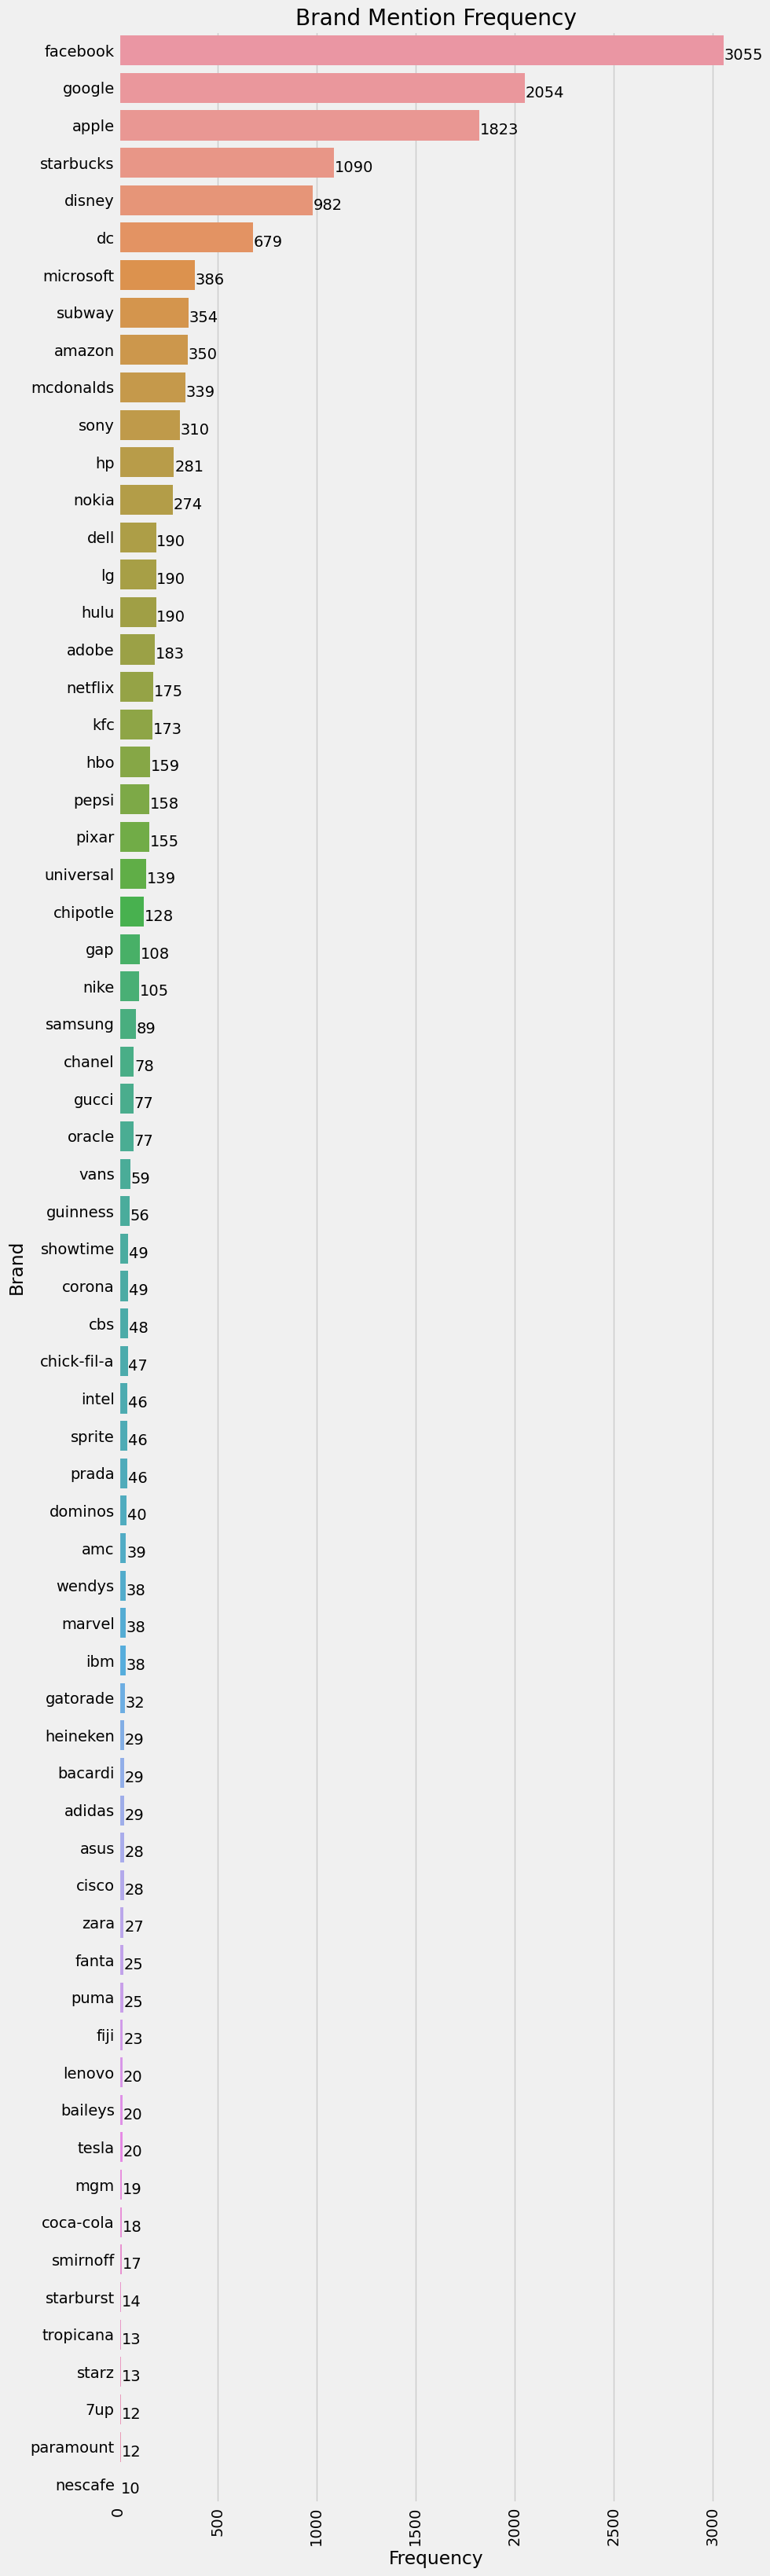

In [205]:
# VISUALIZE BRAND MENTION FREQUENCY

# CREATE BARPLOT
num_brands = len(brand_freqs_df)
plt.figure(figsize=(10, num_brands * 0.5))
barplot = sns.barplot(
    x="Frequency", y="Brand", data=brand_freqs_df, order=brand_freqs_df["Brand"]
)
plt.xticks(rotation=90)
plt.title("Brand Mention Frequency")

# ADD COUNTS AT THE END OF THE BARS
for i, v in enumerate(brand_freqs_df["Frequency"]):
    barplot.text(v + 3, i + 0.25, str(v))

# SAVE VISUALIZATION
plt.tight_layout()
barplot.figure.savefig("report/brand_mention_frequency.png", dpi=300)

plt.show()

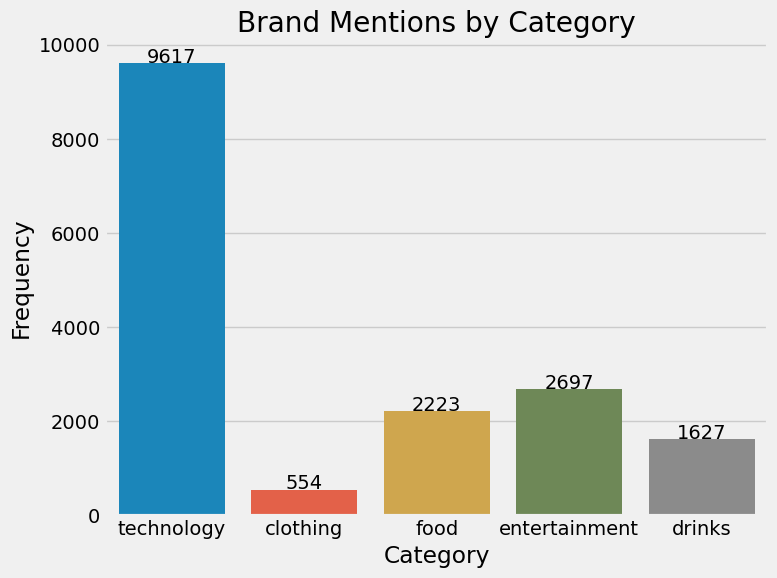

In [206]:
categories = ["technology", "clothing", "food", "entertainment", "drinks"]

# CREATE DATAFRAME
category_df = pd.DataFrame.from_dict(
    category_counts, orient="index", columns=["count"]
).reset_index()
category_df.columns = ["Category", "Count"]

# PLOT DATAFRAME
plt.figure(figsize=(8, 6))
ax = sns.barplot(x="Category", y="Count", data=category_df)
ax.set_title("Brand Mentions by Category")
ax.set_ylabel("Frequency")

# Add counts on top of bars
for i, row in category_df.iterrows():
    ax.text(i, row.Count + 0.5, row.Count, ha="center")

# SAVE VISUALIZATION
plt.tight_layout()
plt.savefig("report/brand_category_mentions.png", dpi=300)

plt.show()

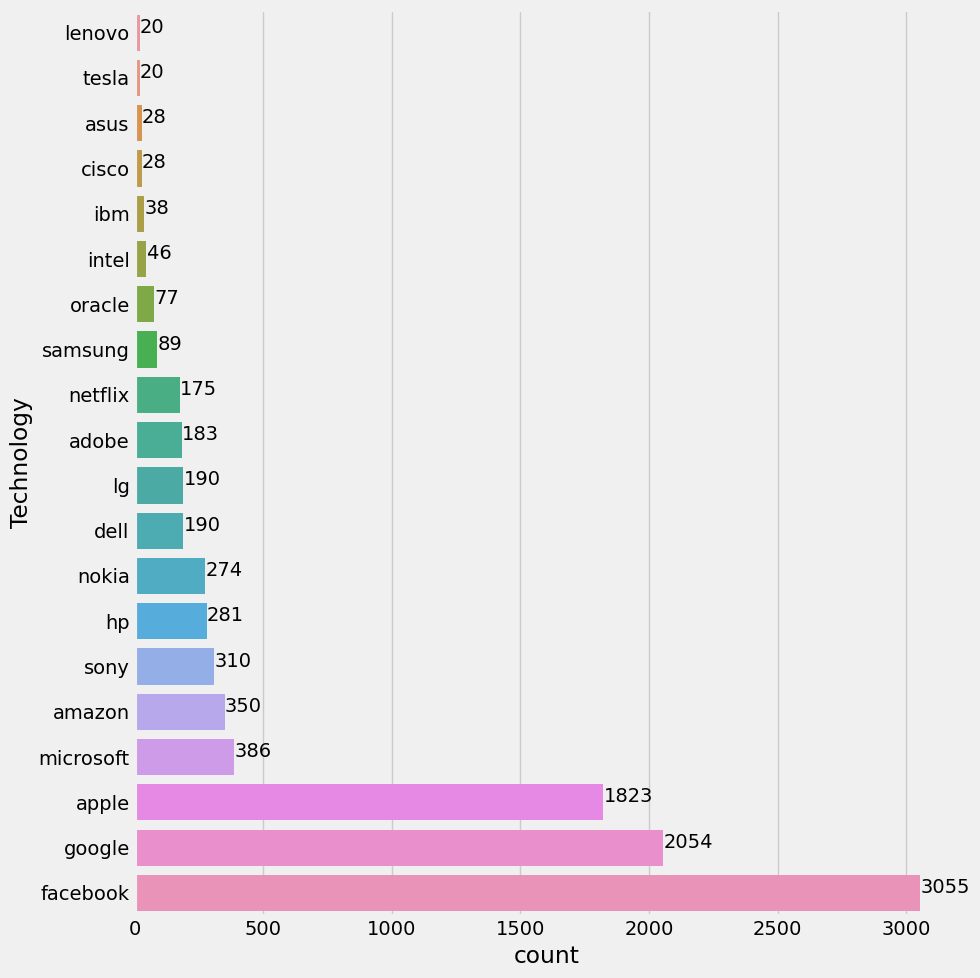

plotting brands within category...0.51 seconds


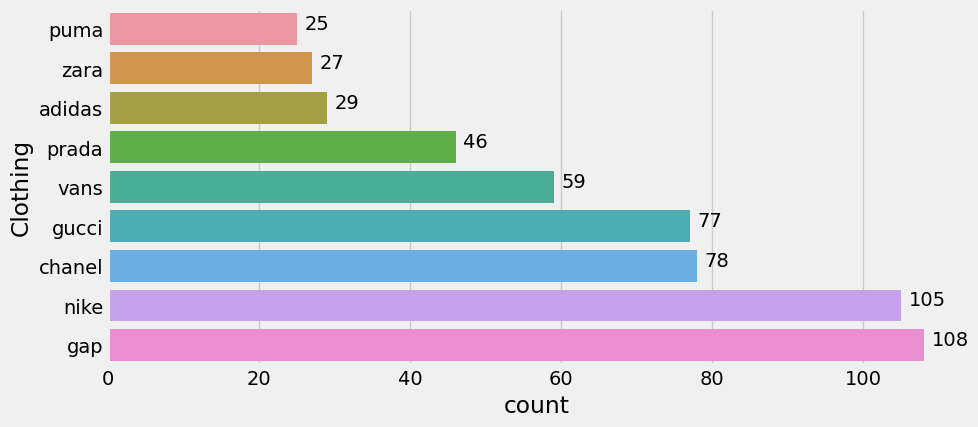

plotting brands within category...0.23 seconds


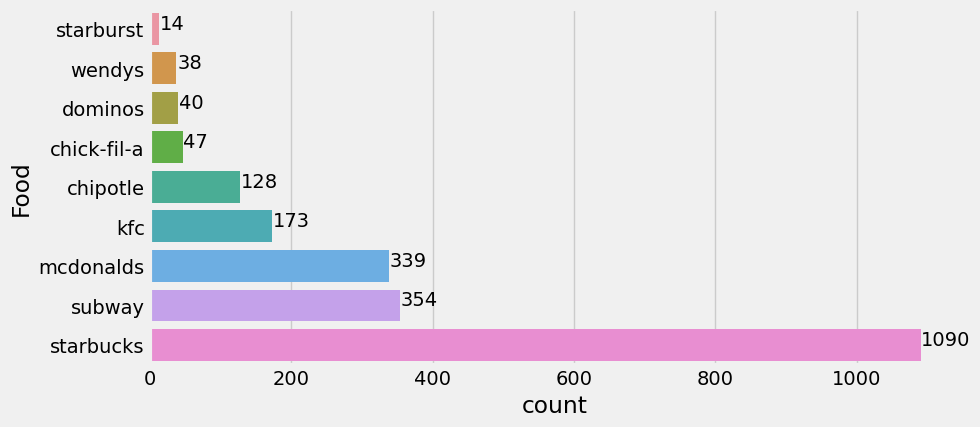

plotting brands within category...0.25 seconds


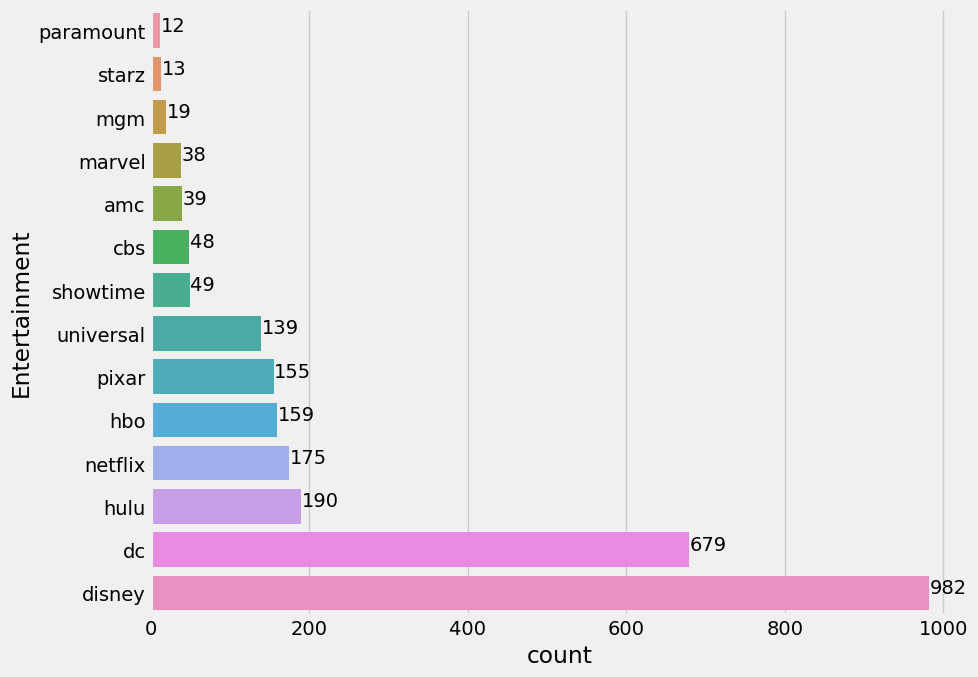

plotting brands within category...0.34 seconds


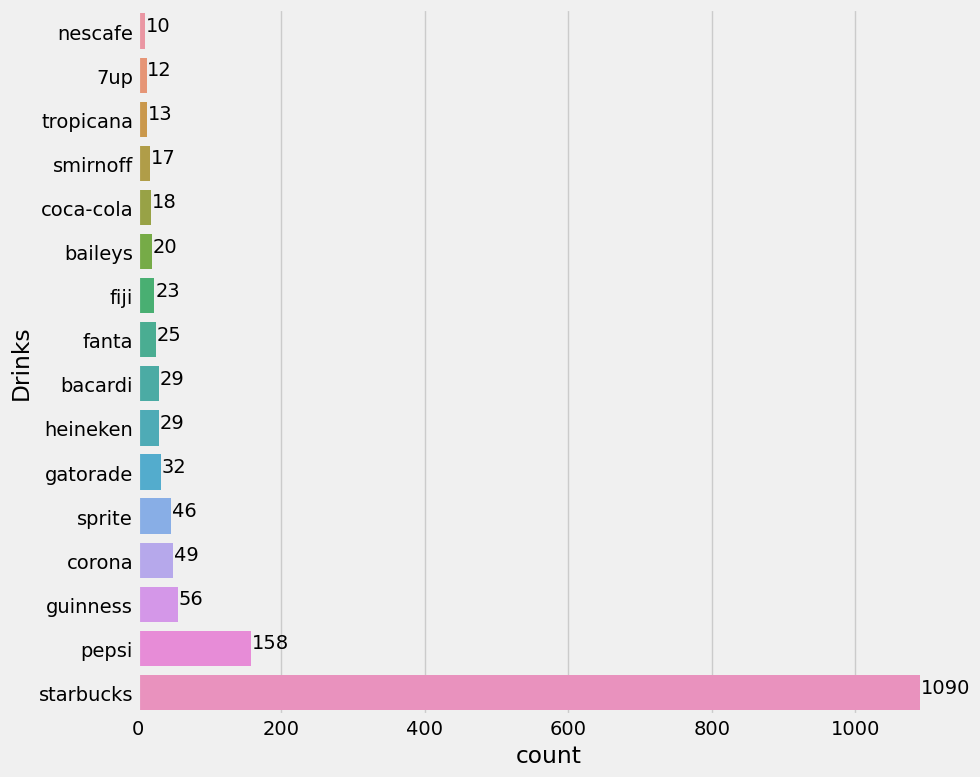

plotting brands within category...0.38 seconds


In [207]:
brand_df = pd.DataFrame.from_dict(counter, orient="index", columns=["count"])
brand_df["count"] = brand_df["count"].astype(int)


@measure_time("plotting brands within category")
def plot_brand_data(
    df: pd.DataFrame,
    filter_condition: Union[List[bool], pd.Series],
    label: str,
) -> None:
    """Plots a horizontal bar chart of the counts in a dataframe, filtered by condition.

    Args:
        df (pd.DataFrame): The dataframe to plot data from.
        filter_condition (Union[List[bool], pd.Series]): A boolean list or series used to filter the dataframe.
        label (str): The label to use for the y-axis.
    """
    # FILTER THE DATAFRAME BASED ON THE PROVIDED CONDITION
    filtered_df = df.loc[filter_condition]

    # SORT THE DATAFRAME BY COUNT
    sorted_df = filtered_df.sort_values("count")

    # PLOT A HORIZONTAL BAR CHART
    plt.figure(figsize=(10, len(sorted_df) * 0.5))
    sns.barplot(x="count", y=sorted_df.index, data=sorted_df, orient="h")

    # SET THE Y-AXIS LABEL
    plt.ylabel(label)

    # ADD COUNT TEXT TO THE RIGHT OF THE BARS
    for i, v in enumerate(sorted_df["count"]):
        plt.text(v + 1, i, str(v))

    # SAVE VISUALIZATION
    plt.tight_layout()
    plt.savefig(f"report/brand_data_{label}.png", dpi=300)
    plt.show()


# CALL FUNCTION FOR EACH CATEGORY
plot_brand_data(brand_df, technology, "Technology")
plot_brand_data(brand_df, clothing, "Clothing")
plot_brand_data(brand_df, food, "Food")
plot_brand_data(brand_df, entertainment, "Entertainment")
plot_brand_data(brand_df, drinks, "Drinks")

### Process Tweets to Identify Brand Mentions

We analyze tweets and identify mentions of specific brands. The process begins by standardizing the text in each tweet, which aids in detecting brand names. Each tweet is analyzed for brand mentions. When a brand is detected, we store the original tweet text, a flag indicating a brand mention, and the brand name itself. Where no brand is mentioned, we record the brand name as `nobrand`.

In [208]:
brand_rows = []
for tweet in df_train["text"]:
    # TOKENIZE EACH TWEET, REMOVE HYPHENS, AND CONVERT ALL WORDS TO LOWERCASE
    tweet_tokens = {word.replace("-", "") for word in tweet.lower().split()}
    # FIND THE INTERSECTION OF TOKENIZED TWEETS AND BRANDS
    brands_in_tweet = tweet_tokens.intersection(BRANDS)
    if brands_in_tweet:
        for brand in brands_in_tweet:
            # APPEND A DICTIONARY WITH TWEET TEXT, BRAND PRESENCE FLAG, AND BRAND NAME TO THE LIST
            brand_rows.append({"tweet": tweet, "brand-presence": 1, "brand": brand})
    else:
        # APPEND A DICTIONARY WITH TWEET TEXT, BRAND PRESENCE FLAG, AND "NOBRAND" TO THE LIST
        brand_rows.append({"tweet": tweet, "brand-presence": 0, "brand": "nobrand"})

# CONVERT THE LIST OF DICTIONARIES INTO A PANDAS DATAFRAME
brands_df = pd.DataFrame(brand_rows)

# PRINT THE FIRST FEW ROWS OF THE DATAFRAME
print(brands_df.head())

                                                                             tweet  \
0  @switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda g...   
1  is upset that he can't update his Facebook by texting it... and might cry as...   
2  @Kenichan I dived many times for the ball. Managed to save 50%  The rest go ...   
3                                  my whole body feels itchy and like its on fire    
4  @nationwideclass no, it's not behaving at all. i'm mad. why am i here? becau...   

   brand-presence     brand  
0               0   nobrand  
1               1  facebook  
2               0   nobrand  
3               0   nobrand  
4               0   nobrand  


In [209]:
# OUTPUT DATASET TO FILE
print(len(brands_df))
brands_df.to_csv("datasets/brands.csv", index=False)

1600185


### Data Generation Using OpenAI's GPT-4 Model

We define parameters for data generation using OpenAI's GPT-4 model. The parameters include the model name, the desired dataset size, and a user prompt that outlines the required data format.

The data format is: 

"tweet"|||brand-presence|||brand

Here, 'tweet' represents a Twitter post, 'brand-presence' is a binary indicator (0 or 1) denoting the presence or absence of a brand in the tweet, and 'brand' is the name of a brand from a predefined list or 'nobrand' when no brand is mentioned in the tweet.

The user prompt also includes examples to guide the data generation process and specifies that the dataset should have an equal number of tweets with and without brand mentions.

After defining the parameters, we use OpenAI's API to generate the data. The API key is retrieved from the environment variables, and a chat completion task is created using the GPT-4 model and the defined user prompt. The generated data is then extracted from the chat completion response.

In [210]:
# DEFINE PARAMETERS FOR DATA GENERATION

MODEL = "gpt-4"

DATASET_SIZE = 10

USER_PROMPT = f"""
    Create some data in the format: 
    
    "tweet"|||brand-presence|||brand 
    
    where:
        tweet is a Twitter post, 
        brand-presence is 0 or 1 indicating presence or absence of a brand in the tweet, and
        brand is a brand named in this list: {str(BRANDS)} or nobrand when brand is 0.

    EXAMPLES:
        "@ashman01 My only complaint about Facebook is they've changed it so much it's confusing"|||1|||facebook
        "@juliet I ate some grapes yesterday and I loved them."|||0|||nobrand
    
    There should be an equal number of tweets with a brand (1) and tweets with no brand (0).

    Create {DATASET_SIZE} data points.
    """

In [211]:
import openai


@measure_time("generating data with GPT-4")
def generate_data(user_prompt: str, model: Optional[str] = "gpt-4") -> str:
    """
    Generate data using OpenAI's GPT-4 model.

    Args:
        user_prompt (str): The user prompt.
        model (str, optional): The model to use. Default is "gpt-4".

    Returns:
        str: The generated data.
    """
    openai.api_key = os.environ["OPENAI_API_KEY"]

    # GENERATE DATA WITH GPT-4 CHAT COMPLETION MODEL
    chat_completion = openai.ChatCompletion.create(
        model=model,
        temperature=0,
        messages=[
            {"role": "user", "content": user_prompt},
        ],
    )
    raw_chat_completion = chat_completion.choices[0].message.content
    return raw_chat_completion


@measure_time("saving generated data")
def save_generated_data(data, filename):
    """
    Function to save generated data to a file.

    Args:
        data (str): The data to be saved.
        filename (str): The name of the file.
    """
    with open(filename, "wb") as f:
        pickle.dump(data, f)


@measure_time("loading generated data")
def load_generated_data(filename):
    """
    Function to load generated data from a file.

    Args:
        filename (str): The name of the file.

    Returns:
        str: The loaded data.
    """
    with open(filename, "rb") as f:
        return pickle.load(f)


# GENERATE DATA WITH GPT-4 (DELETE FILE TO REGENERATE)
generated_data_file = "cache/generated_data.pkl"
if os.path.exists(generated_data_file):
    raw_chat_completion = load_generated_data(generated_data_file)
else:
    raw_chat_completion = generate_data(USER_PROMPT)
    save_generated_data(raw_chat_completion, generated_data_file)

print(json.dumps(raw_chat_completion.split("\n"), indent=4))

loading generated data...0.00 seconds
[
    "\"@james I just bought a new Sony TV, the picture quality is amazing!\"|||1|||sony",
    "\"@lucy I'm going to the park with my dog today.\"|||0|||nobrand",
    "\"@mike Just got my new Adidas shoes, they're so comfortable!\"|||1|||adidas",
    "\"@sarah I can't believe it's already December, this year has flown by.\"|||0|||nobrand",
    "\"@tom I'm loving the new iPhone, Apple really outdid themselves this time.\"|||1|||apple",
    "\"@emma I'm thinking about going to the beach this weekend.\"|||0|||nobrand",
    "\"@jack Just watched the latest Marvel movie, it was incredible!\"|||1|||marvel",
    "\"@lily I made some delicious homemade pizza for dinner.\"|||0|||nobrand",
    "\"@alex I can't get enough of Netflix's new series, it's so good!\"|||1|||netflix",
    "\"@olivia I'm planning a road trip for next month.\"|||0|||nobrand"
]


### Processing and Integrating Generated Data

The raw content generated by the GPT-4 model is processed by splitting it into three parts: 'tweet', 'brand-presence', and 'brand'. This is achieved by separating each line of the raw content on the delimiter '|||'. The processed content is then stored in a structured format as a list of dictionaries.

The processed content is converted into a pandas DataFrame and added to the existing `brands_df` DataFrame. This integration step ensures the newly generated data is combined with any current data for further analysis. Any missing values in the 'brand' column of the DataFrame are filled with 'nobrand'. This step ensures data consistency by providing a placeholder value for tweets where no brand is mentioned.

In [212]:
# SPLIT RAW CONTENT INTO tweet, brand-presence, AND brand
raw_content = raw_chat_completion.split("\n")
processed_content = [s.split("|||") for s in raw_content]

# CONVERT TO DATAFRAME
processed_content_df = pd.DataFrame(
    processed_content, columns=["tweet", "brand-presence", "brand"]
)

# MERGE processed_content_df INTO brands_df
brands_df = pd.concat([brands_df, processed_content_df], ignore_index=True)

# CONVERT 'brand-presence' TO INTEGER
brands_df["brand-presence"] = brands_df["brand-presence"].astype(int)

# FILL MISSING VALUES IN 'brand' WITH 'nobrand'
brands_df["brand"].fillna("nobrand", inplace=True)

# PRINT PROCESSED CONTENT
print(json.dumps(processed_content, indent=4))

[
    [
        "\"@james I just bought a new Sony TV, the picture quality is amazing!\"",
        "1",
        "sony"
    ],
    [
        "\"@lucy I'm going to the park with my dog today.\"",
        "0",
        "nobrand"
    ],
    [
        "\"@mike Just got my new Adidas shoes, they're so comfortable!\"",
        "1",
        "adidas"
    ],
    [
        "\"@sarah I can't believe it's already December, this year has flown by.\"",
        "0",
        "nobrand"
    ],
    [
        "\"@tom I'm loving the new iPhone, Apple really outdid themselves this time.\"",
        "1",
        "apple"
    ],
    [
        "\"@emma I'm thinking about going to the beach this weekend.\"",
        "0",
        "nobrand"
    ],
    [
        "\"@jack Just watched the latest Marvel movie, it was incredible!\"",
        "1",
        "marvel"
    ],
    [
        "\"@lily I made some delicious homemade pizza for dinner.\"",
        "0",
        "nobrand"
    ],
    [
        "\"@alex I can't get eno

In [213]:
print(f"brands_df.shape: {brands_df.shape}")

brands_df.shape: (1600195, 3)


In [214]:
print(f"brands_df.brand.value_counts(): {brands_df.brand.value_counts()}")

brands_df.brand.value_counts(): brand
nobrand      1585100
facebook        3020
google          1983
apple           1779
starbucks       1079
              ...   
tropicana         13
starz             13
paramount         12
7up               12
nescafe           10
Name: count, Length: 65, dtype: int64


In [215]:
print(f"brands_df.tail(6): \n{brands_df.tail(6)}")

brands_df.tail(6): 
                                                                               tweet  \
1600189  "@tom I'm loving the new iPhone, Apple really outdid themselves this time."   
1600190                  "@emma I'm thinking about going to the beach this weekend."   
1600191             "@jack Just watched the latest Marvel movie, it was incredible!"   
1600192                     "@lily I made some delicious homemade pizza for dinner."   
1600193            "@alex I can't get enough of Netflix's new series, it's so good!"   
1600194                           "@olivia I'm planning a road trip for next month."   

         brand-presence    brand  
1600189               1    apple  
1600190               0  nobrand  
1600191               1   marvel  
1600192               0  nobrand  
1600193               1  netflix  
1600194               0  nobrand  


### Brand Mention Distribution Visualization

We create a visual representation of the distribution of brand mentions within a collection of tweets. We use a bar plot to illustrate the count of tweets mentioning a brand versus those not.

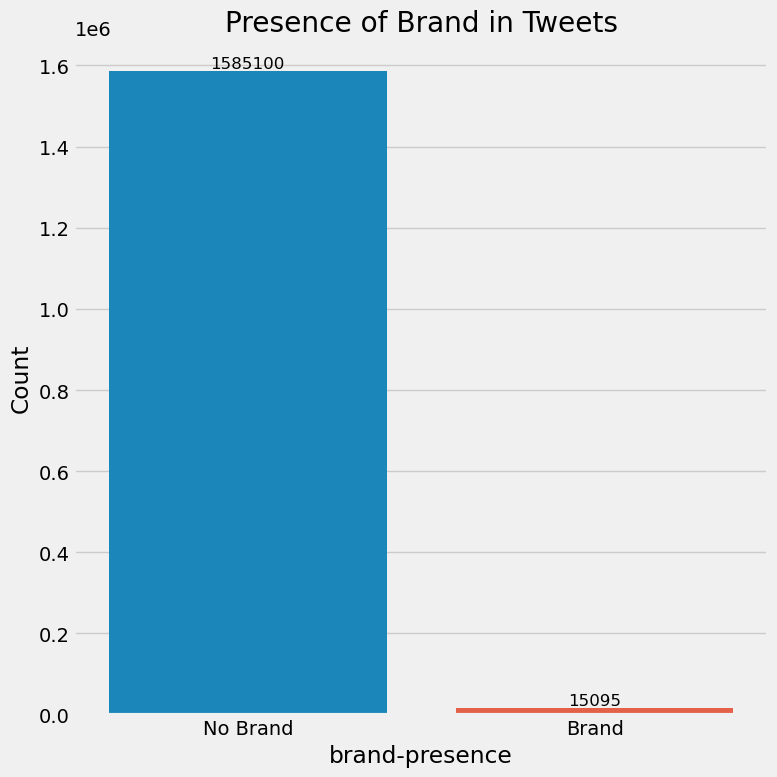

In [216]:
plt.figure(figsize=(8, 8))
ax = sns.countplot(x="brand-presence", data=brands_df)
plt.title("Presence of Brand in Tweets")
plt.ylabel("Count")
plt.xticks([0, 1], ["No Brand", "Brand"])

for p in ax.patches:
    # ADD COUNTS TO BARS
    ax.text(
        p.get_x() + p.get_width() / 2.0,
        p.get_height(),
        "%d" % int(p.get_height()),
        fontsize=12,
        color="black",
        ha="center",
        va="bottom",
    )

# SAVE VISUALIZATION
plt.tight_layout()
plt.savefig("report/brand_count.png", dpi=300)

plt.show()

### Natural Language Toolkit (`nltk`) for Text Processing

We initialize the Natural Language Toolkit (`nltk`), a Python library for processing human language data. It offers tools for various tasks, including classification, tokenization, stemming, tagging, parsing, and semantic reasoning.

Key parts from `nltk` are downloaded: a tokenizer, a part-of-speech tagger, a named entity chunker, a corpus of words, a multilingual lexical database, and a corpus of stopwords. 

The tokenizer helps break down the text into sentences or words, the part-of-speech tagger assigns parts of speech to individual words, and the named entity chunker identifies named entities within the text.

The corpus of words and the multilingual lexical database can be used for tasks such as spellchecking or language identification.

The stopwords corpus lists common words, known as "stop words", in several languages, including English. These words are often filtered out during text processing and rarely have significant meaning.

We generate a set of English stop words to expedite membership checking. This set will be used later in the text processing pipeline to filter out stop words from the text data.


In [217]:
import nltk
from nltk.corpus import stopwords

# PUNKT TOKENIZER FOR SENTENCE TOKENIZATION
nltk.download("punkt", quiet=True)

# TAGGER FOR PART-OF-SPEECH TAGGING
nltk.download("averaged_perceptron_tagger", quiet=True)

# CHUNKER FOR NAMED ENTITY RECOGNITION
nltk.download("maxent_ne_chunker", quiet=True)

# CORPUS OF WORDS FOR SPELLCHECKING OR LANGUAGE IDENTIFICATION
nltk.download("words", quiet=True)

# MULTILINGUAL LEXICAL DATABASE
nltk.download("omw-1.4", quiet=True)

# DOWNLOAD STOPWORDS CORPUS
nltk.download("stopwords", quiet=True)

# CREATE SET OF ENGLISH STOPWORDS FOR FASTER MEMBERSHIP CHECKING
STOP_WORDS = set(stopwords.words("english"))

### Preprocessing Tweets for Text Analysis

We implement a preprocessing function to clean and standardize the text in tweets. This function removes URLs and @mentions, tokenizes the text into individual words, removes stopwords and punctuation, and applies stemming to reduce words to their root form. This preprocessing function is then applied to each tweet in the dataset. A sample of the original and preprocessed tweets is displayed to visually check the preprocessing results. This step ensures the preprocessing function works as expected and the tweets are ready for further text analysis.


In [218]:
import preprocessor as p
from nltk.stem import SnowballStemmer
from concurrent.futures import ThreadPoolExecutor


# SET OPTIONS TO REMOVE URLS AND @MENTIONS
p.set_options(p.OPT.URL, p.OPT.MENTION)

# INITIALIZE STEMMER
STEMMER = SnowballStemmer("english")

# CONVERT STOPWORDS AND PUNCTUATION TO SETS
STOP_WORDS_SET = set(STOP_WORDS)
PUNCTUATION_SET = set(string.punctuation)


def preprocess(tweet: str) -> list:
    """
    Function to preprocess a tweet by removing URLs, @mentions, stopwords and punctuation.
    It also tokenizes and stems the tweet.

    Args:
        tweet (str): The tweet to be preprocessed.

    Returns:
        list: The preprocessed tweet as a list of stemmed tokens.
    """
    # CLEAN TWEET BY REMOVING URLS AND @MENTIONS
    cleaned = p.clean(tweet)
    # TOKENIZE TWEET INTO INDIVIDUAL WORDS
    tokens = re.findall(r"\b\w+\b", cleaned)
    # REMOVE STOPWORDS AND PUNCTUATION FROM TOKENS
    filtered = [
        word
        for word in tokens
        if word not in STOP_WORDS_SET and word not in PUNCTUATION_SET
    ]
    # APPLY STEMMING TO FILTERED TOKENS
    stemmed = [STEMMER.stem(word) for word in filtered]
    return stemmed


@measure_time("preprocessing training data")
def apply_preprocessing(df):
    """
    Function to apply preprocessing to each tweet in the DataFrame using multithreading.

    Args:
        df (DataFrame): The DataFrame containing the tweets.

    Returns:
        DataFrame: The DataFrame with the preprocessed tweets.
    """
    with ThreadPoolExecutor() as executor:
        df["processed_text"] = list(executor.map(preprocess, df["text"]))
    return df


@measure_time("saving preprocessed data")
def save_preprocessed(df, filename):
    """
    Function to save preprocessed DataFrame to a file.

    Args:
        df (DataFrame): The DataFrame to be saved.
        filename (str): The name of the file.
    """
    with open(filename, "wb") as f:
        pickle.dump(df, f)


@measure_time("loading preprocessed data")
def load_preprocessed(filename):
    """
    Function to load preprocessed DataFrame from a file.

    Args:
        filename (str): The name of the file.

    Returns:
        DataFrame: The loaded DataFrame.
    """
    with open(filename, "rb") as f:
        return pickle.load(f)


# LOAD FROM FILE IF EXISTS (DELETE FILE TO RE-PREPROCESS)
preprocessed_file = "cache/preprocessed_train.pkl"
if os.path.exists(preprocessed_file):
    df_train = load_preprocessed(preprocessed_file)
else:
    # USE MULTITHREADING TO APPLY PREPROCESSING
    df_train = apply_preprocessing(df_train)
    save_preprocessed(df_train, preprocessed_file)

# SHOW SAMPLE PROCESSED TWEETS
tweets_sample = df_train[df_train["target"] == 1].head()
for index, row in tweets_sample.iterrows():
    print(f"ORIGINAL: {row['text']}")
    print(f"PROCESSED: {row['processed_text']}\n")

loading preprocessed data...6.48 seconds
ORIGINAL: I LOVE @Health4UandPets u guys r the best!! 
PROCESSED: ['i', 'love', 'u', 'guy', 'r', 'best']

ORIGINAL: im meeting up with one of my besties tonight! Cant wait!!  - GIRL TALK!!
PROCESSED: ['im', 'meet', 'one', 'besti', 'tonight', 'cant', 'wait', 'girl', 'talk']

ORIGINAL: @DaRealSunisaKim Thanks for the Twitter add, Sunisa! I got to meet you once at a HIN show here in the DC area and you were a sweetheart. 
PROCESSED: ['thank', 'twitter', 'add', 'sunisa', 'i', 'got', 'meet', 'hin', 'show', 'dc', 'area', 'sweetheart']

ORIGINAL: Being sick can be really cheap when it hurts too much to eat real food  Plus, your friends make you soup
PROCESSED: ['be', 'sick', 'realli', 'cheap', 'hurt', 'much', 'eat', 'real', 'food', 'plus', 'friend', 'make', 'soup']

ORIGINAL: @LovesBrooklyn2 he has that effect on everyone 
PROCESSED: ['effect', 'everyon']

ORIGINAL: I LOVE @Health4UandPets u guys r the best!! 
PROCESSED: ['i', 'love', 'u', 'guy', 'r', 

In [219]:
# SHOW FIRST FEW ROWS OF PREPROCESSED TRAINING DATA
print("\n".join([str(text) for text in df_train["processed_text"].head()]))

['awww', 'bummer', 'you', 'shoulda', 'got', 'david', 'carr', 'third', 'day', 'd']
['upset', 'updat', 'facebook', 'text', 'might', 'cri', 'result', 'school', 'today', 'also', 'blah']
['i', 'dive', 'mani', 'time', 'ball', 'manag', 'save', '50', 'the', 'rest', 'go', 'bound']
['whole', 'bodi', 'feel', 'itchi', 'like', 'fire']
['behav', 'mad', 'i', 'see']


In [220]:
@measure_time("getting word sentiment frequencies")
def get_word_sentiment_frequencies(df):
    """
    Get word-sentiment frequencies from a DataFrame.

    Args:
        df (pandas.DataFrame): The DataFrame containing the tweets and sentiment labels.

    Returns:
        dict: A dictionary with word-sentiment pairs as keys and their frequencies as values.
    """
    freqs = {}
    for y, tweet in zip(df.target.values.tolist(), df.processed_text):
        for word in tweet:
            pair = (word, y)
            freqs[pair] = freqs.get(pair, 0) + 1

    freqs_sorted = dict(sorted(freqs.items(), key=lambda x: x[1], reverse=True))

    return freqs_sorted


freqs_sorted = get_word_sentiment_frequencies(df_train)

getting word sentiment frequencies...2.43 seconds


In [221]:
print(f"NUMBER OF UNIQUE WORD-SENTIMENT PAIRS: {len(freqs_sorted)}")

NUMBER OF UNIQUE WORD-SENTIMENT PAIRS: 306003


In [222]:
@measure_time("printing sample preprocessed text")
def print_around_average(freqs_sorted: Dict[Tuple[Any, int], int]) -> None:
    """
    Print the first 5 items, 5 items around the average frequency, and last 5 items in a sorted dictionary.

    Args:
        freqs_sorted (dict): The sorted dictionary.
    """
    # PRINT FIRST 5 ITEMS IN THE SORTED DICTIONARY
    print("\n".join(f"{k}: {v}" for k, v in itertools.islice(freqs_sorted.items(), 5)))

    # PRINT 5 ITEMS AROUND THE AVERAGE FREQUENCY
    # Calculate the average frequency
    avg_freq = sum(freqs_sorted.values()) / len(freqs_sorted)

    # Find the index of the first item with a frequency just below the average
    below_avg_index = next(
        i for i, v in enumerate(freqs_sorted.values()) if v < avg_freq
    )

    # Get 5 items around the average frequency
    start_index = below_avg_index - 2  # 2 items before the average
    end_index = below_avg_index + 3  # 2 items after the average

    # Convert dictionary items to a list and slice the 5 items around the average
    around_avg_items = list(freqs_sorted.items())[start_index:end_index]
    print("\n".join(f"{k}: {v}" for k, v in around_avg_items))

    # PRINT LAST 5 ITEMS IN THE SORTED DICTIONARY
    print("\n".join(f"{k}: {v}" for k, v in list(freqs_sorted.items())[-5:]))


print_around_average(freqs_sorted)

('i', 0): 385771
('i', 1): 270072
('go', 0): 79267
('good', 1): 62836
('get', 0): 61504
('cgft', 1): 42
('usawantsmcfli', 1): 42
('lesli', 0): 41
('sandra', 0): 41
('uti', 0): 41
('nemuselo', 1): 1
('holc', 1): 1
('ael', 1): 1
('bigrun', 1): 1
('thewdb', 1): 1
printing sample preprocessed text...0.08 seconds


### Visualization of Sentiment Distribution for Frequently Occurring Word Stems

We create a scatter plot to analyze our dataset's 50 most often occurring word stems. Each point on the plot corresponds to a word stem, positioned according to its occurrence in positive and negative sentiments.

Handling large frequency counts can lead to complexity in graphical representation. To tackle this, we apply a logarithmic transformation to the data. This technique simplifies the visualization of large numbers, making the information easier to understand. Each point on the graph is labeled with the word stem it represents. Additionally, a line is drawn on the plot to represent an equal frequency of positive and negative sentiments. This element aids in quickly determining whether a word stem is primarily associated with positive or negative sentiments in the data.


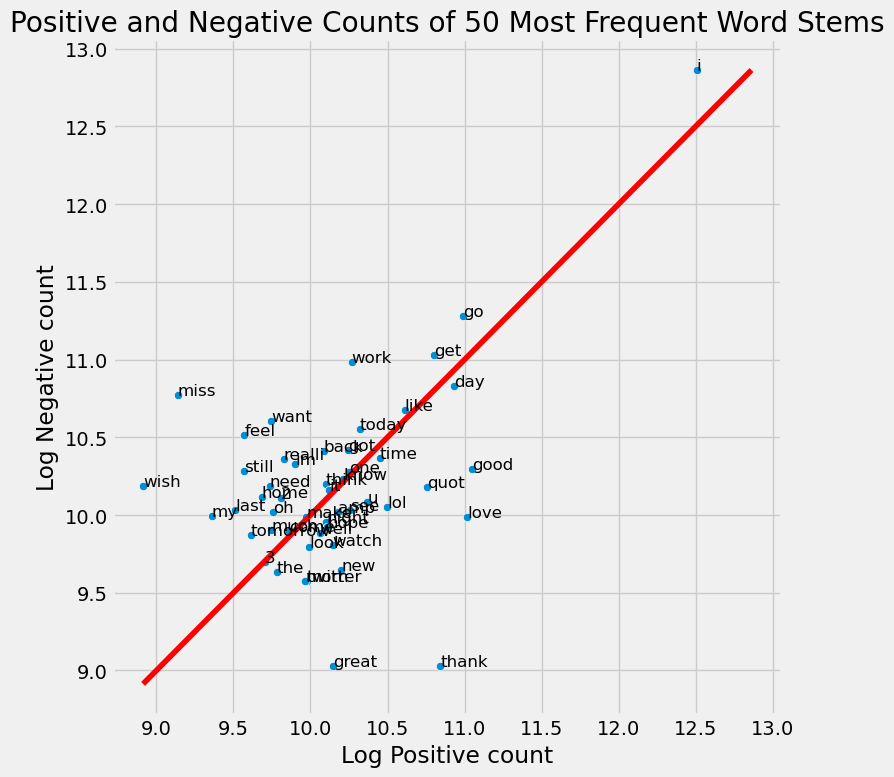

generating sentiment counts plot...0.98 seconds


In [223]:
from adjustText import adjust_text
import warnings

warnings.filterwarnings("ignore")


@measure_time("generating sentiment counts plot")
def generate_sentiment_counts_plot(freqs_sorted, n=50):
    # GET UNIQUE LIST OF WORDS FROM KEYS IN FREQS_SORTED
    word_list = list(set(word for word, sentiment in freqs_sorted.keys()))

    # BUILD LIST OF WORDS WITH POSITIVE AND NEGATIVE SENTIMENT COUNTS
    data = [
        [word, freqs_sorted.get((word, 1), 0), freqs_sorted.get((word, 0), 0)]
        for word in word_list
    ]

    # SORT DATA BY THE SUM OF POSITIVE AND NEGATIVE COUNTS AND LIMIT TO TOP 'n' MOST FREQUENT WORDS
    data = sorted(data, key=lambda x: x[1] + x[2], reverse=True)[:n]

    # PREPARE X AND Y FOR PLOT, APPLY LOG TRANSFORMATION FOR LARGE COUNTS
    x = np.log([x[1] + 1 for x in data])
    y = np.log([x[2] + 1 for x in data])

    # CREATE SCATTER PLOT FOR LOG-TRANSFORMED COUNTS
    plt.figure(figsize=(8, 8))
    sns.scatterplot(x=x, y=y)
    plt.title(f"Positive and Negative Counts of {n} Most Frequent Word Stems")
    plt.xlabel("Log Positive count")
    plt.ylabel("Log Negative count")

    # ADD ANNOTATIONS TO EACH POINT IN SCATTER PLOT, ADJUST TO AVOID OVERLAP
    for i in range(len(data)):
        plt.text(x[i], y[i], data[i][0], fontsize=12)

    # ADD RED LINE FROM MINIMUM TO MAXIMUM VALUE ON BOTH AXES
    min_val = min(np.min(x), np.min(y))
    max_val = max(np.max(x), np.max(y))
    plt.plot([min_val, max_val], [min_val, max_val], color="red")

    # SAVE VISUALIZATION
    plt.tight_layout()
    plt.savefig("report/positive_and_negative_counts.png", dpi=300)

    plt.show()


# Call the function
generate_sentiment_counts_plot(freqs_sorted)

## Build & Evaluate Models

### Weights & Biases (`wandb`) Setup

We use Weights & Biases (wandb) for experiment tracking. This MLOps tool allows us to compare metrics from different runs and visualize model performance.

In [224]:
import wandb

wandb.finish()
wandb.login(key=os.getenv("WANDB_API_KEY"))

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/user/.netrc


True

### Brand Classifer

The `BrandClassifier` class is a comprehensive tool created to identify brand mentions in tweets. It operates with a specified machine-learning model and a vectorizer responsible for transforming text data into a numerical format that the model can process. Once configured, the `BrandClassifier` can train the model with given data, predict based on new data inputs, and evaluate the accuracy of the model's performance. The class structures data into training, testing, and validation sets.

In [225]:
import joblib
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer


class BrandClassifier:
    """A generic brand classifier."""

    @measure_time("initializing classifier")
    def __init__(
        self, classifier, vectorizer: CountVectorizer = CountVectorizer()
    ) -> None:
        """
        Initializes the classifier with a vectorizer and classifier.

        Args:
            classifier: The classifier to use.
            vectorizer: The vectorizer to use. Defaults to CountVectorizer().
        """
        self.model = Pipeline([("vectorizer", vectorizer), ("classifier", classifier)])
        datetime_stamp = datetime.datetime.now().strftime("%Y-%m-%d-%H-%M-%S")
        classifier_name = self.model.named_steps["classifier"].__class__.__name__
        wandb.init(
            project="brand-sentiment-analysis",
            name=f"{datetime_stamp}-{classifier_name}",
        )

    @measure_time("training classifier")
    def fit(self, X_train: List[str], y_train: List[str]) -> None:
        """
        Fits the model to the training data.

        Args:
            X_train: The training data.
            y_train: The training labels.
        """
        self.model.fit(X_train, y_train)

    @measure_time("predicting sentiment")
    def predict(self, X: List[str]) -> List[str]:
        """
        Predicts the labels for the given data.

        Args:
            X: The data to predict labels for.

        Returns:
            List[str]: The predicted labels.
        """
        return self.model.predict(X)

    @measure_time("evaluating classifier")
    def evaluate(self, X: List[str], y: List[str]) -> Tuple[float, float, float, float]:
        """
        Evaluates the model on the given data and returns the accuracy, precision, recall, and F1 score.

        Args:
            X: The data to evaluate the model on.
            y: The true labels for the data.

        Returns:
            Tuple[float, float, float, float]: The accuracy, precision, recall, and F1 score.
        """
        y_pred = self.predict(X)
        accuracy = accuracy_score(y, y_pred)
        precision = precision_score(y, y_pred)
        recall = recall_score(y, y_pred)
        f1 = f1_score(y, y_pred)
        return accuracy, precision, recall, f1

    @measure_time("printing classifier results")
    def print_scores(
        self, scores: Tuple[float, float, float, float], data_name: str
    ) -> None:
        """
        Prints the accuracy, precision, recall, and F1 score.

        Args:
            scores: The scores to print.
            data_name: The name of the data the scores are for.
        """
        accuracy, precision, recall, f1 = scores
        print(f"{data_name} Accuracy: {accuracy:.4f}")
        print(f"{data_name} Precision: {precision:.4f}")
        print(f"{data_name} Recall: {recall:.4f}")
        print(f"{data_name} F1: {f1:.4f}")

    @measure_time("finishing run")
    def finish(self, scores: Tuple[float, float, float, float]) -> None:
        """
        Finishes the wandb run and saves the trained model as an artifact.

        Args:
            scores: The scores of the model.
        """
        # INITIALIZE NEW ARTIFACT
        classifier_name = self.model.named_steps["classifier"].__class__.__name__
        accuracy, precision, recall, f1 = scores

        artifact = wandb.Artifact(
            classifier_name,
            type="model",
            description="Trained model for brand sentiment analysis",
            metadata={
                "accuracy": accuracy,
                "precision": precision,
                "recall": recall,
                "f1": f1,
            },
        )

        # ADD MODEL TO ARTIFACT
        joblib.dump(self.model, "model.pkl")
        artifact.add_file("model.pkl", name="classifier_name")

        # LOG ARTIFACT TO wandb
        wandb.log_artifact(artifact)

        # DELETE TEMPORARY ARTIFACT FROM FILESYSTEM
        os.remove("model.pkl")

        # FINISH RUN
        wandb.finish()

    @measure_time("splitting data")
    def split_data(
        self, X: List[str], y: List[str]
    ) -> Tuple[List[str], List[str], List[str], List[str], List[str], List[str]]:
        """
        Splits the data into training, test, validation sets.

        Args:
            X: The data to split.
            y: The labels to split.

        Returns:
            Tuple[List[str], List[str], List[str], List[str], List[str], List[str]]: The train, test, validate data and labels.
        """
        # SPLIT DATA INTO TRAINING SET AND TEMP SET WITH 80/20 SPLIT
        X_train, X_temp, y_train, y_temp = train_test_split(
            X, y, test_size=0.2, random_state=42
        )

        # SPLIT TEMP SET INTO VALIDATION SET AND TEST SET WITH 50/50 SPLIT
        X_val, X_test, y_val, y_test = train_test_split(
            X_temp, y_temp, test_size=0.5, random_state=42
        )

        return X_train, y_train, X_test, y_test, X_val, y_val

    @measure_time("running classifier")
    def run(self, X: List[str], y: List[str]) -> None:
        """
        Runs the entire process from training to testing.

        Args:
            X: The data to use.
            y: The labels to use.
        """
        # SPLIT DATA
        X_train, y_train, X_test, y_test, X_val, y_val = self.split_data(X, y)

        # FIT MODEL
        self.fit(X_train, y_train)

        # EVALUATE MODEL ON VALIDATION SET
        val_scores = self.evaluate(X_val, y_val)
        self.print_scores(val_scores, "Validation")

        # EVALUATE MODEL ON TEST SET
        test_scores = self.evaluate(X_test, y_test)
        self.print_scores(test_scores, "Test")

        # FINISH RUN
        self.finish(test_scores)

### Multinomial Naive Bayes (`MultinomialNB`)

The Multinomial Naive Bayes classifier is a widely recognized and used tool in text classification. This classifier is based on Bayes' theorem, a principle in probability theory and statistics that describes the probability of an event based on prior knowledge of conditions that might be related to the event. The Multinomial Naive Bayes classifier assumes that all features, such as words in a tweet, are independent of each other. This is often called the 'naive' assumption, hence the name Naive Bayes.

This classifier is effective when dealing with features that are discrete counts. In text classification, this could be the number of times a specific word appears in a document or a tweet. The Multinomial Naive Bayes classifier requires these counts to be integers, aligning perfectly with word counts in text data. This makes the Multinomial Naive Bayes classifier an ideal choice for our text classification needs, as it can effectively handle and make predictions based on the vectorized text data.

In [226]:
from sklearn.naive_bayes import MultinomialNB

BrandClassifier(MultinomialNB()).run(brands_df["tweet"], brands_df["brand-presence"])

initializing classifier...4.83 seconds
splitting data...0.20 seconds
training classifier...9.60 seconds
predicting sentiment...1.32 seconds
evaluating classifier...1.39 seconds
Validation Accuracy: 0.9902
Validation Precision: 0.2165
Validation Recall: 0.0139
Validation F1: 0.0261
printing classifier results...0.00 seconds
predicting sentiment...1.09 seconds
evaluating classifier...1.16 seconds
Test Accuracy: 0.9899
Test Precision: 0.2736
Test Recall: 0.0184
Test F1: 0.0346
printing classifier results...0.00 seconds


finishing run...7.14 seconds
running classifier...19.51 seconds


### Linear Support Vector Classifier (`LinearSVC`)

The Linear Support Vector Classifier is a Support Vector Machine (SVM) often used for text classification tasks. SVMs are supervised learning methods for classification, regression, and outliers detection. The LinearSVC works by identifying the best boundary or 'hyperplane' that separates different data classes. This is achieved by maximizing the margin between the classes in the training data.

One of the strengths of LinearSVC is its ability to handle high-dimensional data. In text classification, once the text data is vectorized, it can result in a high-dimensional feature space, where each dimension corresponds to a unique word in the text.

In [227]:
from sklearn.svm import LinearSVC

BrandClassifier(LinearSVC()).run(brands_df["tweet"], brands_df["brand-presence"])

initializing classifier...5.50 seconds
splitting data...0.18 seconds
training classifier...27.47 seconds
predicting sentiment...1.04 seconds
evaluating classifier...1.12 seconds
Validation Accuracy: 0.9964
Validation Precision: 0.7880
Validation Recall: 0.8444
Validation F1: 0.8152
printing classifier results...0.00 seconds
predicting sentiment...1.19 seconds
evaluating classifier...1.26 seconds
Test Accuracy: 0.9960
Test Precision: 0.7759
Test Recall: 0.8346
Test F1: 0.8042
printing classifier results...0.00 seconds


finishing run...13.79 seconds
running classifier...43.83 seconds


### Logistic Regression

Logistic Regression is a statistical model used to predict the probability of a specific class or event. Despite its name, Logistic Regression is used for classification tasks, not regression tasks. In text classification, it's used to predict the likelihood of a specific word belonging to a particular category or class, such as whether a tweet mentions a brand.

Logistic Regression is known for its simplicity and efficiency. It uses a logistic function to model a binary dependent variable, making it a suitable choice for tasks where the output can be one of two possible outcomes. In our case, this could be whether a tweet mentions a brand or not.

In [228]:
from sklearn.linear_model import LogisticRegression

BrandClassifier(LogisticRegression()).run(
    brands_df["tweet"], brands_df["brand-presence"]
)

initializing classifier...5.52 seconds
splitting data...0.17 seconds
training classifier...21.56 seconds
predicting sentiment...1.13 seconds
evaluating classifier...1.20 seconds
Validation Accuracy: 0.9966
Validation Precision: 0.7931
Validation Recall: 0.8583
Validation F1: 0.8244
printing classifier results...0.00 seconds
predicting sentiment...1.20 seconds
evaluating classifier...1.27 seconds
Test Accuracy: 0.9963
Test Precision: 0.7790
Test Recall: 0.8658
Test F1: 0.8201
printing classifier results...0.00 seconds


finishing run...9.01 seconds
running classifier...33.25 seconds


In [229]:
# PRINT METRICS
metrics.print_metrics()

Metrics:
  running classifier: 96.59 seconds
  training classifier: 58.63 seconds
  finishing run: 29.94 seconds
  generating word cloud from training data: 17.50 seconds
  initializing classifier: 15.86 seconds
  evaluating classifier: 7.39 seconds
  predicting sentiment: 6.97 seconds
  loading preprocessed data: 6.48 seconds
  installing required packages: 3.56 seconds
  getting word sentiment frequencies: 2.43 seconds
  plotting brands within category: 1.72 seconds
  generating sentiment counts plot: 0.98 seconds
  splitting data: 0.55 seconds
  printing sample preprocessed text: 0.08 seconds
  printing classifier results: 0.00 seconds
  loading generated data: 0.00 seconds
Total time: 248.68 seconds
